In [1]:
import numpy as np
import matplotlib.pyplot as plt

def dataParser(x, y):
    xTrain, yTrain = open(x), open(y)
    feature = xTrain.readline().split(",")
    yTrain.readline()
    weight, ground = [], []
    for line in xTrain:
        L = line
        L = L.split(",")
        L = list(map(float, L))
        weight.append(L)
        ground.append(int(yTrain.readline()))
    xTrain.close()
    yTrain.close()
    return [feature, weight, ground]

def comp_confmat(actual, predicted):
    np.seterr(divide='ignore')
    classes = np.unique(actual)
    confmat = np.zeros((len(classes), len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
           confmat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))
    TP = np.array([confmat[i,i] for i in range(len(classes))])
    FP = np.array([np.sum(confmat[:,i]) - confmat[i,i] for i in range(len(classes))])
    FN = np.array([np.sum(confmat[i]) - confmat[i,i] for i in range(len(classes))])
    TN = np.array([np.sum(confmat) for i in range(len(classes))]) - FP - FN + TP
    return confmat

def metricCalculator(confmat, display = True):
    classCnt = len(confmat[0])
    TP = np.array([confmat[i,i] for i in range(classCnt)])
    FP = np.array([np.sum(confmat[:,i]) - confmat[i,i] for i in range(classCnt)])
    FN = np.array([np.sum(confmat[i]) - confmat[i,i] for i in range(classCnt)])
    TN = np.array([np.sum(confmat) for i in range(classCnt)]) - FP - FN + TP
    #accuracy = (TP + TN)/(TP + TN + FP + FN) do not use this
    recall = TP/(TP + FP) 
    precision = TP/(TP + FN)
    NPV = TN/(TN + FN)
    FPR = FP/(FP + TN) #1 - specificity
    FDR = FP/(FP + TP)
    F_m = lambda B : (1+B**2)*precision*recall/(precision*B**2+recall)
    metrics = np.array([precision, recall, NPV, FPR, FDR, F_m(1), F_m(2)])
    metrics[np.isnan(metrics)] = 0
    microMetric = np.sum(confmat, axis = 1).dot(metrics.T)/np.sum(confmat)*100
    macroMetric = np.sum(metrics, axis=1)/classCnt*100
    metricNames = ["Precision", "Recall", "NPV", "FPR", "FDR", "F(B=1)", "F(B=2)"]
    if display:
        print("  Total accuracy:    {:.6s}%".format(str(np.sum(TP)/np.sum(confmat)*100)))
        print("# "*23)
        print("#                    Micro          Macro   #")
        for i in range(len(microMetric)):
            print(f"# {metricNames[i]:10s}:        {str(microMetric[i]):.6s}%        {str(macroMetric[i]):.6s}% #".format())
        print("# "*23)
    return metrics    

def plotParameter(parameters, accuracy, parameterName):
        x_labels = [parameterName+' = {}'.format(parameter) for parameter in parameters]
        plt.plot(x_labels, accuracy, marker='o', markersize=6, color='skyblue', linewidth=2)
        plt.title('Parameter vs Accuracy Plot')
        plt.xlabel('Changing Parameter')
        plt.ylabel('% Accuracy')
        plt.show()

In [2]:
[features, weights, grounds] = dataParser("X_train.csv", "y_train.csv")
test_parse = dataParser("X_test.csv", "y_test.csv")
test_weights, test_ground = np.array(test_parse[1], dtype = float), np.array(test_parse[2], dtype = int)
weights = np.array(weights, dtype = float)
grounds = np.array(grounds, dtype = int)

In [3]:
from sklearn.svm import SVC
samplesCount = len(grounds)
splitW = [weights[i::5] for i in range(5)]
splitG = [grounds[i::5] for i in range(5)]  

Training set classes/number of occurances
Class '3', number of occurances: 16
Class '4', number of occurances: 130
Class '5', number of occurances: 1166
Class '6', number of occurances: 1758
Class '7', number of occurances: 704
Class '8', number of occurances: 140
Class '9', number of occurances: 4


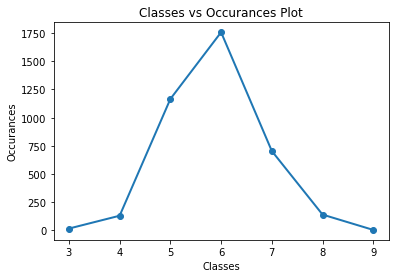


Test set classes/number of occurances
Class '3', number of occurances: 4
Class '4', number of occurances: 33
Class '5', number of occurances: 291
Class '6', number of occurances: 440
Class '7', number of occurances: 176
Class '8', number of occurances: 35
Class '9', number of occurances: 1


In [4]:
classes, counts = np.unique(grounds, return_counts=True)
print("Training set classes/number of occurances")
for i in range(len(classes)): print(f"Class '{classes[i]}', number of occurances: {counts[i]}")

plt.plot(classes, counts, marker='o', markersize=6, linewidth=2)
plt.title('Classes vs Occurances Plot')
plt.xlabel('Classes')
plt.ylabel('Occurances')
plt.show()
classes, counts = np.unique(test_ground, return_counts=True)
print("\nTest set classes/number of occurances")
for i in range(len(classes)): print(f"Class '{classes[i]}', number of occurances: {counts[i]}")

Average Accuracy: 44.8698% for hyperparameter C = 0.001
Average Accuracy: 48.3920% for hyperparameter C = 0.01
Average Accuracy: 73.3538% for hyperparameter C = 0.1
Average Accuracy: 75.7785% for hyperparameter C = 1
Average Accuracy: 74.1450% for hyperparameter C = 10


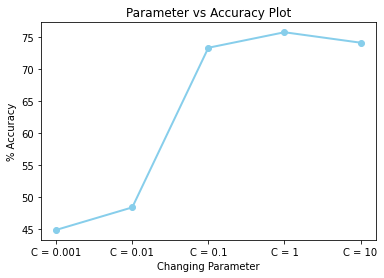

In [13]:
prev = 0
estimates = [[],[],[],[],[]]
CList = [0.001, 0.01, 0.1, 1, 10]
accuracy = []
for C in CList:
  totalCorrect = 0
  for k in range(5):
    trainX, trainY = splitW.copy(), splitG.copy()
    validateX, validateY = trainX.pop(k), trainY.pop(k)
    trainXflat, trainYflat = [], []
    for i in range(4):
      trainXflat.extend(trainX[i])
      trainYflat.extend(trainY[i])
    clf = SVC(C = C)
    clf.fit(trainXflat,trainYflat)
    estimates[k] = clf.predict(validateX)
    correct = 0
    for idx in range(len(validateY)):
      if estimates[k][idx] == validateY[idx]: correct += 1
    totalCorrect += correct
  accuracy.append(totalCorrect/samplesCount*100)
  print(f"Average Accuracy: {totalCorrect/samplesCount*100:.4f}% for hyperparameter C = {C}")
plotParameter(CList, accuracy, 'C')

In [9]:
clfModel = SVC(kernel = 'linear', C = 1.0)
clfModel.fit(weights,grounds)
estimatesTest = clfModel.predict(test_weights)
conf = comp_confmat(test_ground, estimatesTest)
print(conf)
_ = metricCalculator(conf)

[[  0.   0.   4.   0.   0.   0.   0.]
 [  0.   0.  28.   5.   0.   0.   0.]
 [  0.   0. 230.  61.   0.   0.   0.]
 [  0.   0.  57. 357.  26.   0.   0.]
 [  0.   0.   0.  56. 120.   0.   0.]
 [  0.   0.   0.   5.  30.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.]]
  Total accuracy:    72.142%
# # # # # # # # # # # # # # # # # # # # # # # 
#                    Micro          Macro   #
# Precision :        72.142%        32.622% #
# Recall    :        66.701%        30.522% #
# NPV       :        94.097%        96.411% #
# FPR       :        7.8276%        3.3333% #
# FDR       :        25.849%        12.334% #
# F(B=1)    :        69.296%        31.524% #
# F(B=2)    :        67.711%        30.912% #
# # # # # # # # # # # # # # # # # # # # # # # 


D:\Files\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
D:\Files\Anaconda\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Average Accuracy: 73.4048% for hyperparameter gamma = 0.0625
Average Accuracy: 72.2307% for hyperparameter gamma = 0.125
Average Accuracy: 69.0914% for hyperparameter gamma = 0.25
Average Accuracy: 57.4017% for hyperparameter gamma = 0.5
Average Accuracy: 45.1506% for hyperparameter gamma = 1
Average Accuracy: 44.8698% for hyperparameter gamma = 2


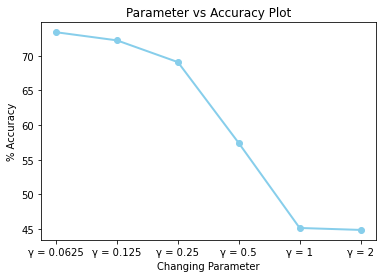

In [43]:
prev = 0
estimates = [[],[],[],[],[]]
gammaList = [0.0625, 0.125, 0.25, 0.5, 1, 2]
accuracy = []
for gamma in gammaList:
  totalCorrect = 0
  for k in range(5):
    trainX, trainY = splitW.copy(), splitG.copy()
    validateX, validateY = trainX.pop(k), trainY.pop(k)
    trainXflat, trainYflat = [], []
    for i in range(4):
      trainXflat.extend(trainX[i])
      trainYflat.extend(trainY[i])
    clf = SVC(kernel = "rbf", gamma = gamma, C = 0.1)
    clf.fit(trainXflat,trainYflat)
    estimates[k] = clf.predict(validateX)
    correct = 0
    for idx in range(len(validateY)):
      if estimates[k][idx] == validateY[idx]: correct += 1
    totalCorrect += correct
  accuracy.append(totalCorrect/samplesCount*100)
  print(f"Average Accuracy: {totalCorrect/samplesCount*100:.4f}% for hyperparameter gamma = {gamma}")

plotParameter(gammaList, accuracy, 'γ')

In [11]:
clfModel = SVC(kernel = 'rbf', gamma = 0.0625, C = 0.1)
clfModel.fit(weights,grounds)
estimatesTest = clfModel.predict(test_weights)
conf = comp_confmat(test_ground, estimatesTest)
print(conf)
_ = metricCalculator(conf)

[[  0.   0.   4.   0.   0.   0.   0.]
 [  0.   0.  27.   6.   0.   0.   0.]
 [  0.   0. 229.  62.   0.   0.   0.]
 [  0.   0.  45. 379.  16.   0.   0.]
 [  0.   0.   0.  77.  99.   0.   0.]
 [  0.   0.   0.  13.  22.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.]]
  Total accuracy:    72.142%
# # # # # # # # # # # # # # # # # # # # # # # 
#                    Micro          Macro   #
# Precision :        72.142%        31.582% #
# Recall    :        66.866%        31.056% #
# NPV       :        94.522%        96.370% #
# FPR       :        8.1317%        3.2415% #
# FDR       :        25.684%        11.800% #
# F(B=1)    :        68.976%        31.069% #
# F(B=2)    :        67.588%        30.999% #
# # # # # # # # # # # # # # # # # # # # # # # 


D:\Files\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
D:\Files\Anaconda\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
